# RNN Simple — Comprendre le Vanishing Gradient

## Objectif
Ce notebook construit un **RNN simple (SimpleRNN)** pour prédire `Total_reservations`
à partir des données historiques de `df_venues_final.csv`.

Il illustre le **problème du vanishing gradient** : lors de la rétropropagation
à travers le temps (BPTT), les gradients sont multipliés par la même matrice de poids
à chaque pas de temps. Si les valeurs propres de cette matrice sont < 1, les gradients
**disparaissent exponentiellement** avec la longueur de la séquence — le réseau
« oublie » les dépendances lointaines.

## Plan
1. Chargement et normalisation des données
2. Création des séquences temporelles (fenêtre glissante)
3. Architecture du Simple RNN
4. Entraînement + capture des normes de gradients
5. Visualisation du vanishing gradient

## 1 — Imports

On utilise **PyTorch** pour construire le RNN manuellement (ce qui permet d'accéder
aux gradients couche par couche), **scikit-learn** pour normaliser les données,
et **matplotlib** pour les visualisations.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler

# Reproductibilité
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version : {torch.__version__}")
print(f"Device utilisé  : {'cuda' if torch.cuda.is_available() else 'cpu'}")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version : 2.10.0
Device utilisé  : cpu


## 2 — Chargement et exploration des données

### Description des colonnes clés
| Colonne | Rôle |
|---|---|
| `Total_reservations` | **Cible** : nombre de réservations ce jour-là |
| `GLOBAL` | Trafic global du restaurant |
| `Temp` | Température (°C) |
| `pluie` | Précipitations (mm) |
| `Semaine` / `Annee` | Numéro de semaine / année |
| `jour_*` | Indicateurs binaires du jour de la semaine |
| `Greve_nationale`, `jour_ferie.` | Perturbateurs potentiels |

On trie d'abord les données chronologiquement (année → semaine → jour de la semaine)
pour respecter l'ordre temporel avant de créer les séquences.

In [3]:
DATA_PATH = "../data/df_venues_final.csv"

df = pd.read_csv(DATA_PATH, sep=";")

# Affichage rapide
print("Shape :", df.shape)
print("\nTypes :\n", df.dtypes)
print("\nAperçu :")
df.head(10)

Shape : (250, 17)

Types :
 GLOBAL                  int64
jour_ferie.             int64
pont.conge.             int64
holiday                 int64
Semaine                 int64
Annee                   int64
Temp                    int64
pluie                 float64
autre                   int64
Greve_nationale         int64
prof_nationale          int64
Total_reservations      int64
jour_jeudi               bool
jour_lundi               bool
jour_mardi               bool
jour_mercredi            bool
jour_vendredi            bool
dtype: object

Aperçu :


,GLOBAL,jour_ferie.,pont.conge.,holiday,Semaine,Annee,Temp,pluie,autre,Greve_nationale,prof_nationale,Total_reservations,jour_jeudi,jour_lundi,jour_mardi,jour_mercredi,jour_vendredi
0,240,0,0,0,36,2022,20,3.1,1,0,0,203,False,True,False,False,False
1,542,0,0,0,36,2022,17,0.4,0,0,0,257,False,False,True,False,False
2,657,0,0,0,36,2022,17,0.5,1,0,0,220,False,False,False,True,False
3,607,0,0,0,36,2022,15,0.4,1,0,0,181,True,False,False,False,False
4,461,0,0,0,36,2022,15,0.4,1,0,0,149,False,False,False,False,True
5,612,0,0,0,37,2022,16,0.0,0,0,0,208,False,True,False,False,False
6,682,0,0,0,37,2022,22,0.1,0,0,0,271,False,False,True,False,False
7,649,0,0,0,37,2022,18,3.5,0,0,0,241,False,False,False,True,False
8,653,0,0,0,37,2022,18,0.3,0,0,0,258,True,False,False,False,False
9,422,0,0,0,37,2022,14,0.0,0,0,0,134,False,False,False,False,True


## 3 — Prétraitement et création des séquences

### Pourquoi normaliser ?
Le RNN utilise une fonction d'activation `tanh` dont la sortie est dans $[-1, 1]$.
Si les entrées sont sur des échelles très différentes (ex. `GLOBAL` ≃ 500 vs `pluie` ≃ 0–15),
les gradients sont déséquilibrés. On applique un **MinMaxScaler** pour tout ramener dans $[0, 1]$.

### Fenêtre glissante (sliding window)
Pour transformer la série temporelle en données supervisées, on construit des paires :
$$
(X^{(t-T+1)}, X^{(t-T+2)}, \ldots, X^{(t)})\;\longrightarrow\; y^{(t+1)}
$$
avec $T$ la taille de la fenêtre temporelle.

**Pourquoi tester plusieurs valeurs de T ?**
Plus $T$ est grand, plus le RNN doit propagager le gradient loin en arrière dans le temps,
ce qui amplifie le phénomène de vanishing gradient.

In [4]:
# ── Colonnes features / cible ──────────────────────────────────────────────
FEATURES = [
    "GLOBAL", "Temp", "pluie", "autre",
    "Greve_nationale", "prof_nationale",
    "jour_ferie.", "pont.conge.", "holiday",
    "jour_lundi", "jour_mardi", "jour_mercredi", "jour_jeudi", "jour_vendredi",
]
TARGET = "Total_reservations"

# ── Tri chronologique ──────────────────────────────────────────────────────
# On reconstitue un ordre temporel : Année → Semaine → jour de la semaine
day_order = {
    "jour_lundi": 0, "jour_mardi": 1, "jour_mercredi": 2,
    "jour_jeudi": 3, "jour_vendredi": 4,
}
df["day_num"] = df[list(day_order.keys())].idxmax(axis=1).map(day_order)
df = df.sort_values(["Annee", "Semaine", "day_num"]).reset_index(drop=True)

# ── Normalisation ──────────────────────────────────────────────────────────
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[FEATURES])          # (N, n_features)
y_scaled = scaler_y.fit_transform(df[[TARGET]])           # (N, 1)

print(f"Nombre de jours   : {len(df)}")
print(f"Nombre de features: {len(FEATURES)}")

# ── Fonction de création des séquences ────────────────────────────────────
def make_sequences(X: np.ndarray, y: np.ndarray, window: int):
    """
    Transforme (N, F) → (N-window, window, F)  pour X
                       → (N-window,)             pour y   (valeur à t+1)
    """
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window : i])          # fenêtre de longueur window
        ys.append(y[i])                        # cible : pas suivant
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

# ── On prépare UNE configuration (window=10) pour l'entraînement principal ─
WINDOW = 10
X_seq, y_seq = make_sequences(X_scaled, y_scaled, WINDOW)

# Train / Test split (80 / 20 — sans mélange pour respecter l'ordre temporel)
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print(f"\nWindow size : {WINDOW}")
print(f"Train : {X_train.shape}  →  {y_train.shape}")
print(f"Test  : {X_test.shape}   →  {y_test.shape}")

# Conversion en tenseurs PyTorch
X_tr = torch.tensor(X_train).to(DEVICE)   # (N, T, F)
y_tr = torch.tensor(y_train).to(DEVICE)   # (N, 1)
X_te = torch.tensor(X_test).to(DEVICE)
y_te = torch.tensor(y_test).to(DEVICE)

train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=16, shuffle=True)

Nombre de jours   : 250
Nombre de features: 14

Window size : 10
Train : (192, 10, 14)  →  (192, 1)
Test  : (48, 10, 14)   →  (48, 1)


## 4 — Architecture du Simple RNN

### Formule mathématique
À chaque pas de temps $t$, le SimpleRNN calcule :

$$
h_t = \tanh\!\bigl(W_{ih}\, x_t + b_{ih} + W_{hh}\, h_{t-1} + b_{hh}\bigr)
$$

- $x_t \in \mathbb{R}^F$ : vecteur d'entrée au pas $t$
- $h_t \in \mathbb{R}^H$ : état caché (mémoire du réseau)
- $W_{ih}$ : poids d'entrée → caché
- $W_{hh}$ : poids caché → caché (matrice **récurrente** — source du vanishing)
- $\tanh$ : saturation entre $-1$ et $1$

### Pourquoi le vanishing gradient ?
Lors de la BPTT (BackPropagation Through Time), le gradient de la loss par rapport
à $h_1$ fait le produit :

$$
\frac{\partial \mathcal{L}}{\partial h_1}
= \frac{\partial \mathcal{L}}{\partial h_T}
  \prod_{t=2}^{T} \frac{\partial h_t}{\partial h_{t-1}}
= \frac{\partial \mathcal{L}}{\partial h_T}
  \prod_{t=2}^{T} W_{hh}^{\top} \,\mathrm{diag}\!\bigl(\tanh'\!(h_{t-1})\bigr)
$$

- $\tanh'(x) = 1 - \tanh^2(x) \leq 1$ → chaque facteur atténue le gradient
- Si $\|W_{hh}\| < 1$ ou que $\tanh'$ est petit, le produit tend vers **0 exponentiellement**
- Résultat : le modèle **n'apprend plus à partir des pas de temps éloignés**

### Architecture choisie
```
Input  : (batch, T=10, 14 features)
   ↓
SimpleRNN(hidden_size=32)   →  sortie : h_T de dim 32
   ↓
Linear(32 → 1)              →  prédiction de Total_reservations normalisée
```

In [5]:
class SimpleRNNModel(nn.Module):
    """
    Un SimpleRNN suivi d'une couche linéaire de sortie.

    Paramètres
    ----------
    input_size  : nombre de features par pas de temps
    hidden_size : dimension de l'état caché h_t
    output_size : dimension de la sortie (1 ici)
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int = 1):
        super().__init__()
        # batch_first=True → entrée de forme (batch, seq_len, input_size)
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            nonlinearity="tanh",   # tanh par défaut — source de vanishing
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x : (batch, T, F)
        out, h_n = self.rnn(x)   # out : (batch, T, H),  h_n : (1, batch, H)
        # On n'utilise que le DERNIER état caché h_T
        last_hidden = out[:, -1, :]   # (batch, H)
        return self.fc(last_hidden)   # (batch, 1)


# ── Instanciation ──────────────────────────────────────────────────────────
INPUT_SIZE  = len(FEATURES)   # 14
HIDDEN_SIZE = 32

model = SimpleRNNModel(INPUT_SIZE, HIDDEN_SIZE).to(DEVICE)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nNombre total de paramètres : {total_params}")

SimpleRNNModel(
  (rnn): RNN(14, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

Nombre total de paramètres : 1569


## 5 — Entraînement + capture des gradients

### Ce qu'on mesure
Après chaque epoch, on enregistre la **norme L2 des gradients** (`grad.norm()`)
de chaque couche de poids :
- `rnn.weight_ih_l0` : poids entrée → caché
- `rnn.weight_hh_l0` : **poids récurrents** (ceux responsables du vanishing)
- `fc.weight`        : poids de la couche de sortie

On s'attend à voir les gradients de `weight_hh_l0` diminuer ou rester très petits
par rapport à ceux de la couche de sortie.

In [6]:
EPOCHS    = 100
LR        = 1e-3

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Dictionnaire pour stocker l'historique des gradients par couche
grad_history = {
    "rnn.weight_ih_l0": [],   # poids entrée → caché
    "rnn.weight_hh_l0": [],   # poids récurrents (vanishing ici !)
    "fc.weight"        : [],   # poids couche de sortie
}
loss_history = {"train": [], "test": []}

for epoch in range(1, EPOCHS + 1):
    # ── Phase d'entraînement ─────────────────────────────────────────────
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)               # (batch, 1)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(X_train)

    # ── Capture des normes de gradient ───────────────────────────────────
    for name, param in model.named_parameters():
        if name in grad_history and param.grad is not None:
            grad_history[name].append(param.grad.norm().item())

    # ── Loss de test ─────────────────────────────────────────────────────
    model.eval()
    with torch.no_grad():
        test_pred = model(X_te)
        test_loss = criterion(test_pred, y_te).item()

    loss_history["train"].append(epoch_loss)
    loss_history["test"].append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | "
              f"Train Loss : {epoch_loss:.5f} | "
              f"Test  Loss : {test_loss:.5f}")

print("\nEntraînement terminé.")

Epoch  10/100 | Train Loss : 0.02250 | Test  Loss : 0.01381
Epoch  20/100 | Train Loss : 0.02131 | Test  Loss : 0.01046
Epoch  30/100 | Train Loss : 0.01910 | Test  Loss : 0.01269
Epoch  40/100 | Train Loss : 0.01897 | Test  Loss : 0.01142
Epoch  50/100 | Train Loss : 0.01799 | Test  Loss : 0.01122
Epoch  60/100 | Train Loss : 0.01902 | Test  Loss : 0.00927
Epoch  70/100 | Train Loss : 0.01678 | Test  Loss : 0.00964
Epoch  80/100 | Train Loss : 0.01475 | Test  Loss : 0.00971
Epoch  90/100 | Train Loss : 0.01435 | Test  Loss : 0.01062
Epoch 100/100 | Train Loss : 0.01489 | Test  Loss : 0.01075

Entraînement terminé.


## 6 — Visualisation

### Graphiques produits
1. **Courbe de loss** (train / test) — convergence du modèle  
2. **Normes des gradients par couche** — mise en évidence du vanishing gradient  
3. **Prédictions vs valeurs réelles** sur le jeu de test  
4. **Vanishing gradient selon la longueur de séquence** — on ré-entraîne des mini-modèles
   avec différentes tailles de fenêtre $T \in \{2, 5, 10, 20\}$ et on compare
   la norme moyenne du gradient sur `weight_hh_l0` à la fin de l'entraînement.

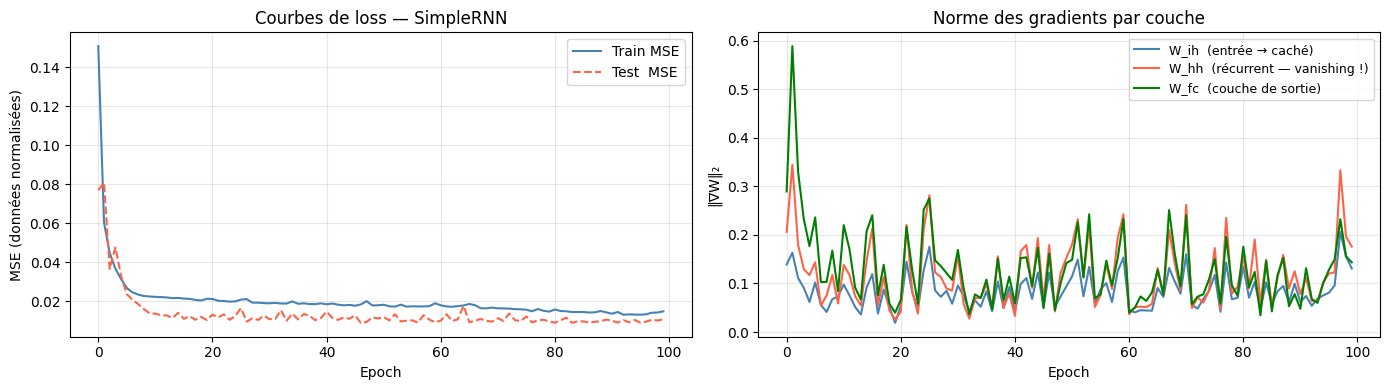

Sauvegardé dans img/rnn_loss_gradients.png


In [7]:
# ── Figure 1 : Loss train / test ──────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

ax = axes[0]
ax.plot(loss_history["train"], label="Train MSE", color="steelblue")
ax.plot(loss_history["test"],  label="Test  MSE", color="tomato", linestyle="--")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (données normalisées)")
ax.set_title("Courbes de loss — SimpleRNN")
ax.legend()
ax.grid(alpha=0.3)

# ── Figure 2 : Normes des gradients ───────────────────────────────────────
ax = axes[1]
colors = {"rnn.weight_ih_l0": "steelblue",
          "rnn.weight_hh_l0": "tomato",
          "fc.weight"        : "green"}
labels = {"rnn.weight_ih_l0": "W_ih  (entrée → caché)",
          "rnn.weight_hh_l0": "W_hh  (récurrent — vanishing !)",
          "fc.weight"        : "W_fc  (couche de sortie)"}

for name, grads in grad_history.items():
    ax.plot(grads, label=labels[name], color=colors[name])

ax.set_xlabel("Epoch")
ax.set_ylabel("‖∇W‖₂")
ax.set_title("Norme des gradients par couche")
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../img/rnn_loss_gradients.png", dpi=150, bbox_inches="tight")
plt.show()
print("Sauvegardé dans img/rnn_loss_gradients.png")

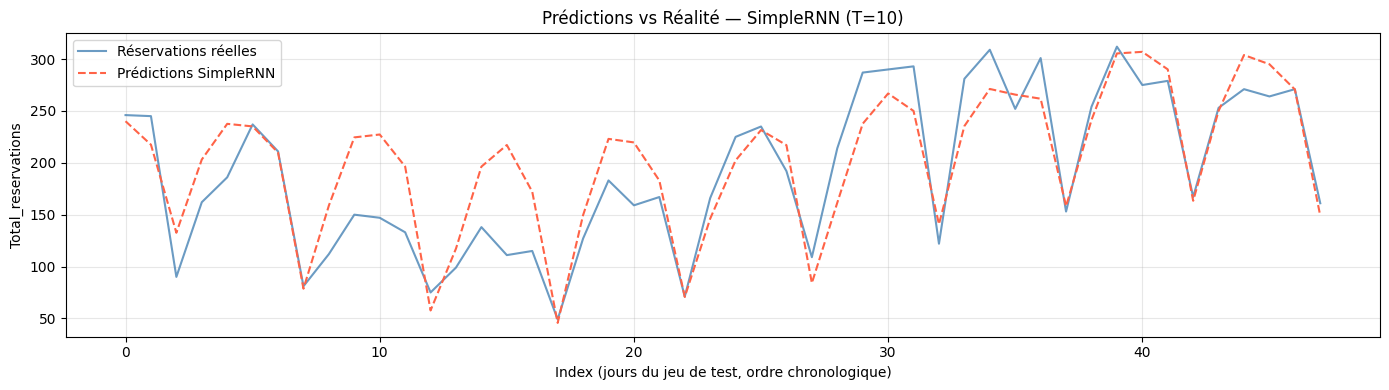

MAE : 29.3 réservations
R²  : 0.7390


In [8]:
# ── Figure 3 : Prédictions vs réalité ────────────────────────────────────
model.eval()
with torch.no_grad():
    preds_norm = model(X_te).cpu().numpy()         # (N_test, 1)
    preds = scaler_y.inverse_transform(preds_norm) # dé-normalisation
    y_real = scaler_y.inverse_transform(y_te.cpu().numpy())

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_real,  label="Réservations réelles",  color="steelblue", alpha=0.8)
ax.plot(preds,   label="Prédictions SimpleRNN", color="tomato",    linestyle="--")
ax.set_xlabel("Index (jours du jeu de test, ordre chronologique)")
ax.set_ylabel("Total_reservations")
ax.set_title("Prédictions vs Réalité — SimpleRNN (T=10)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../img/rnn_predictions.png", dpi=150, bbox_inches="tight")
plt.show()

# Évaluation simple
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_real, preds)
r2  = r2_score(y_real, preds)
print(f"MAE : {mae:.1f} réservations")
print(f"R²  : {r2:.4f}")

## 7 — Expérience : Vanishing Gradient selon la longueur de séquence

On entraîne le **même modèle** (mêmes hyper-paramètres) sur différentes tailles
de fenêtre $T \in \{2, 5, 10, 20\}$.

**Hypothèse** : plus $T$ est grand, plus le gradient sur `W_hh` (poids récurrents)
sera faible à la fin de l'entraînement.

En pratique, le SimpleRNN « sature » vite et devient incapable d'exploiter les
dépendances longues, contrairement au LSTM et au GRU qui ont des mécanismes de portes
pour contourner ce problème.


── Fenêtre T=2 ──────────────
  Norme moyenne ‖∇W_hh‖ (10 dernières epochs) : 0.054707

── Fenêtre T=5 ──────────────
  Norme moyenne ‖∇W_hh‖ (10 dernières epochs) : 0.127083

── Fenêtre T=10 ──────────────
  Norme moyenne ‖∇W_hh‖ (10 dernières epochs) : 0.102819

── Fenêtre T=20 ──────────────
  Norme moyenne ‖∇W_hh‖ (10 dernières epochs) : 0.142867


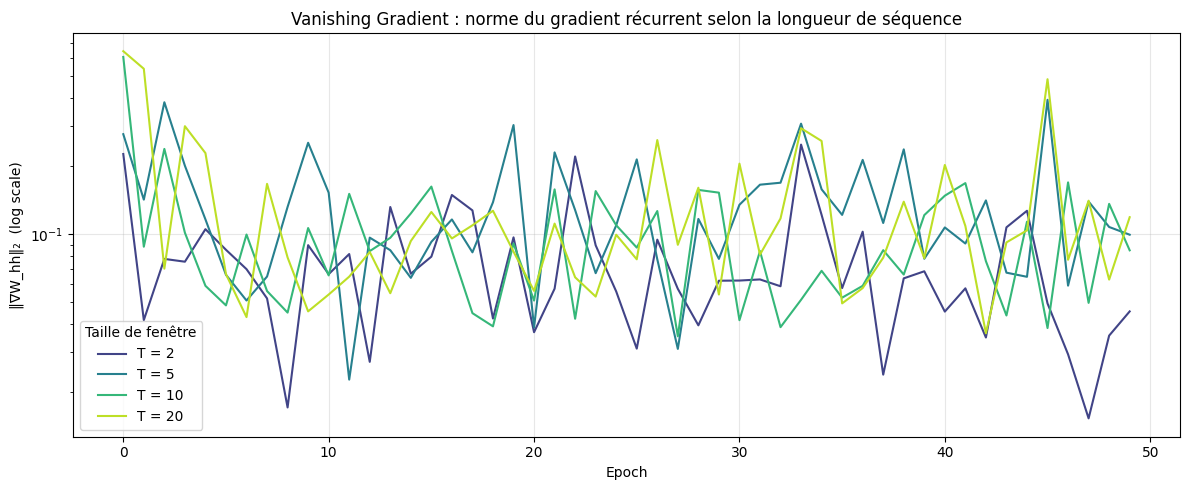

Sauvegardé dans img/rnn_vanishing_gradient.png


In [9]:
WINDOWS_TO_TEST = [2, 5, 10, 20]
EPOCHS_EXP      = 50   # moins d'epochs pour aller vite

results = {}   # window → liste de normes grad W_hh par epoch

for win in WINDOWS_TO_TEST:
    print(f"\n── Fenêtre T={win} ──────────────")

    # Séquences
    Xs, ys = make_sequences(X_scaled, y_scaled, win)
    sp = int(0.8 * len(Xs))
    Xt = torch.tensor(Xs[:sp], dtype=torch.float32).to(DEVICE)
    yt = torch.tensor(ys[:sp], dtype=torch.float32).to(DEVICE)
    loader = DataLoader(TensorDataset(Xt, yt), batch_size=16, shuffle=True)

    # Modèle frais
    m = SimpleRNNModel(INPUT_SIZE, HIDDEN_SIZE).to(DEVICE)
    opt = torch.optim.Adam(m.parameters(), lr=LR)
    crit = nn.MSELoss()

    grad_norms_hh = []
    for ep in range(1, EPOCHS_EXP + 1):
        m.train()
        for xb, yb in loader:
            opt.zero_grad()
            loss = crit(m(xb), yb)
            loss.backward()
            opt.step()
        # Norme du gradient de W_hh après la dernière batch de l'epoch
        if m.rnn.weight_hh_l0.grad is not None:
            grad_norms_hh.append(m.rnn.weight_hh_l0.grad.norm().item())

    results[win] = grad_norms_hh
    avg_last10 = np.mean(grad_norms_hh[-10:]) if len(grad_norms_hh) >= 10 else np.mean(grad_norms_hh)
    print(f"  Norme moyenne ‖∇W_hh‖ (10 dernières epochs) : {avg_last10:.6f}")

# ── Visualisation ─────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))
palette = plt.cm.viridis(np.linspace(0.2, 0.9, len(WINDOWS_TO_TEST)))

for color, win in zip(palette, WINDOWS_TO_TEST):
    ax.plot(results[win], label=f"T = {win}", color=color)

ax.set_xlabel("Epoch")
ax.set_ylabel("‖∇W_hh‖₂  (log scale)")
ax.set_yscale("log")
ax.set_title("Vanishing Gradient : norme du gradient récurrent selon la longueur de séquence")
ax.legend(title="Taille de fenêtre")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../img/rnn_vanishing_gradient.png", dpi=150, bbox_inches="tight")
plt.show()
print("Sauvegardé dans img/rnn_vanishing_gradient.png")

## 8 — Conclusion : Limites du SimpleRNN

| Problème | Cause | Conséquence |
|---|---|---|
| **Vanishing gradient** | Multiplication répétée par $W_{hh}^{\top}\,\mathrm{diag}(\tanh')$ | Oublie les dépendances longues (ex. variations saisonnières à plusieurs semaines) |
| **Exploding gradient** | Si $\|W_{hh}\| > 1$ | Divergence numérique (moins fréquent avec `tanh`) |
| **Mémoire courte** | Conséquence du vanishing | Le modèle n'exploite en pratique que les ~3-5 derniers pas de temps |

### Solutions connues
- **LSTM** (Long Short-Term Memory) : portes d'oubli, d'entrée et de sortie qui régulent
  le flux d'information → gradient peut traverser de longues séquences sans disparaître
- **GRU** (Gated Recurrent Unit) : version simplifiée du LSTM, moins de paramètres
- **Gradient clipping** : borne la norme du gradient pour éviter l'explosion
- **Transformers** : mécanisme d'attention globale — aucune récurrence, pas de vanishing

> **À retenir** : sur nos données de réservations (séries avec saisonnalité hebdomadaire
> et annuelle), un SimpleRNN sera limité à la fenêtre courte visible. Un LSTM ou GRU
> sera nécessaire pour capter des tendances à plus longue portée.